# P5 – Estabilidad y topología de redes

Este notebook está pensado para Google Colab y forma parte de la Práctica 5 del tema de **redes complejas y dinámica en redes**.

En esta práctica se analizará el comportamiento de tres tipos de dinámica de redes vistas en teoría dependiendo de las topologías también vistas en teoría.

Cada ejercicio analizará una dinámica para cada una de las topologías.


## 0. Preparación del entorno

En esta sección instalamos y cargamos las librerías necesarias (principalmente `networkx`, `numpy` y `matplotlib`).

In [1]:
!pip install networkx --quiet
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
%matplotlib inline



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\jordi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Ejercicio 1 – Comparar estabilidad de difusión en distintas topologías

Queremos analizar cómo cambia la estabilidad y la velocidad de convergencia de un proceso de **difusión lineal**
sobre distintas topologías de red con el mismo número de nodos y grado medio aproximado:

- Red aleatoria Erdős–Rényi (ER)
- Red de mundo pequeño (WS, Watts–Strogatz)
- Red libre de escala (BA, Barabási–Albert)

Considera el modelo discreto de difusión:
$
x(t+1) = x(t) - \alpha L x(t),
$
donde $L$ es la matriz laplaciana del grafo y $\alpha > 0$ es un paso de integración.

### Tareas

1. Genera tres redes con `N = 50` nodos y grado medio aproximado `⟨k⟩ ≈ 6` (una ER, una WS, una BA).
2. Calcula el laplaciano de cada red y sus autovalores.
3. Determina un valor máximo de $\alpha$ para que el esquema sea estable (pista: condición de estabilidad lineal tipo $|1-\alpha\lambda_i|<1$ para todos los autovalores $\lambda_i$ del laplaciano).
4. Elige un $\alpha$ estable (común o distinto para cada red) y simula la difusión desde un estado inicial con un nodo caliente (valor 1) y el resto a 0.
5. Representa gráficamente la evolución temporal de la norma $\|x(t)\|$ o del máximo de los nodos, y compara entre las tres topologías.


**Preguntas:**
1. ¿Qué diferencias aprecias en la rapidez de convergencia entre las redes ER, WS y BA?  
   **Respuesta:** Normalmente la ER converge más rápido que WS cuando el reenlace es bajo, porque su conectividad es más homogénea. La BA puede mostrar convergencia rápida en promedio, pero con una dinámica más desigual: los hubs difunden muy rápido, mientras que los nodos periféricos tardan más. WS suele ser la más lenta si conserva estructura de anillo.
2. ¿Cómo se relaciona la rapidez de convergencia con los autovalores del Laplaciano?  
   **Respuesta:** La velocidad de convergencia está ligada a los autovalores del Laplaciano. Un mayor rango espectral (especialmente un $lambda_2$ más grande) suele implicar difusión más rápida. Además, el límite de estabilidad depende de $lambda_{\max}$, que restringe el paso $\alpha$.
3. ¿Qué ocurre si configuramos un valor de α mayor que algún $α_{max}$?  
   **Respuesta:** Se rompe la condición de estabilidad $|1-\alpha\lambda_i|<1$. El sistema empieza a oscilar y puede divergir (la norma $\|x(t)\|$ crece en lugar de decrecer). En la simulación se observa inestabilidad numérica o valores que se disparan.

### Ejercicio 1 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

ER: lambda_max ≈ 13.459, alpha_max_estable ≈ 0.149
WS: lambda_max ≈ 10.159, alpha_max_estable ≈ 0.197
BA: lambda_max ≈ 24.397, alpha_max_estable ≈ 0.082

Usaremos alpha = 0.05


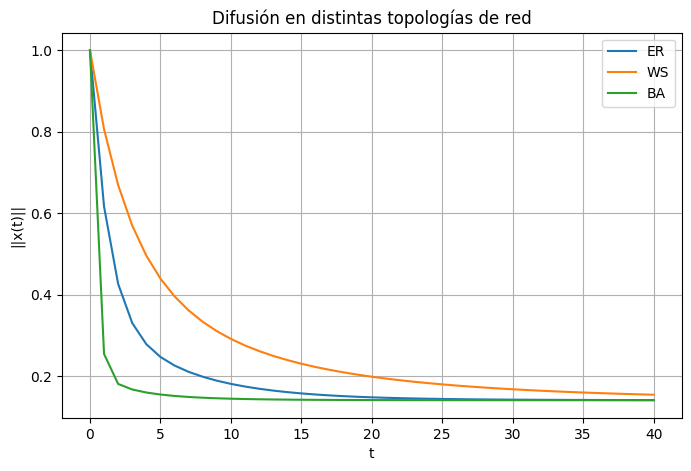

In [2]:
# Parámetros comunes
N = 50
k_target = 6
p_er = k_target / (N-1)        # para ER
k_ws = 6                       # vecinos en WS
p_rewire = 0.1                 # probabilidad de reenlace en WS
m_ba = 3                       # para BA (grado medio ≈ 2m)

# Generación de redes
G_er = nx.erdos_renyi_graph(N, p_er, seed=1)
G_ws = nx.watts_strogatz_graph(N, k_ws, p_rewire, seed=2)
G_ba = nx.barabasi_albert_graph(N, m_ba, seed=3)

graphs = {"ER": G_er, "WS": G_ws, "BA": G_ba}

def laplacian_matrix(G):
    return nx.laplacian_matrix(G).astype(float).todense()

laplacians = {name: laplacian_matrix(G) for name, G in graphs.items()}

# Cálculo de autovalores y condicion de estabilidad
eigvals_dict = {name: np.sort(np.real(eigvals(L))) for name, L in laplacians.items()}

for name, vals in eigvals_dict.items():
    lam_max = vals[-1]
    alpha_max = 2.0 / lam_max  # condición |1 - alpha*lambda| < 1
    print(f"{name}: lambda_max ≈ {lam_max:.3f}, alpha_max_estable ≈ {alpha_max:.3f}")

# Elegimos un alpha estable común pequeño
alpha = 0.05
print("\nUsaremos alpha =", alpha)

def simulate_diffusion(L, alpha, T=40, hot_node=0):
    N = L.shape[0]
    x = np.zeros(N)
    x[hot_node] = 1.0
    history = [x.copy()]
    for _ in range(T):
        x = x - alpha * (L @ x)
        history.append(x.copy())
    return np.array(history)

T = 40
histories = {}
for name, L in laplacians.items():
    histories[name] = simulate_diffusion(L, alpha, T=T, hot_node=0)

# Graficamos la evolución de la norma
plt.figure(figsize=(8,5))
for name, H in histories.items():
    norms = np.linalg.norm(H, axis=1)
    plt.plot(norms, label=name)
plt.xlabel('t')
plt.ylabel('||x(t)||')
plt.title('Difusión en distintas topologías de red')
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 2 – Sincronización y conectividad algebraica

Considera de nuevo las tres topologías (ER, WS y BA) anteriores, ahora con osciladores de Kuramoto acoplados:
$
\dot{\theta}_i = \omega_i + K \sum_j a_{ij} \sin(\theta_j - \theta_i).
$

### Tareas
1. Genera de nuevo las tres redes con los mismos parámetros.
2. Calcula el segundo autovalor más pequeño del laplaciano, $\lambda_2$ (conectividad algebraica) para cada red.
3. Asigna frecuencias naturales cercanas (por ejemplo, $\omega_i \sim \mathcal{N}(1, 0.01)$).
4. Simula la dinámica con distintos valores de $K$ y observa para qué valores la red se sincroniza. Muestra en la gráfica la fase $r(t)$ de sta manera se podrá ver que la red se ha sincronizado cuando $r(t) = 1$
5. Relaciona la facilidad de sincronización con el valor de $\lambda_2$ de cada red.


**Preguntas:**
1. ¿Qué topología requiere menor acoplamiento $K$ para sincronizar?  
   **Respuesta:** Suele requerir menor $K$ la red con mayor conectividad algebraica $\lambda_2$ (a menudo ER), porque está más “bien conectada”. WS con poco reenlace suele necesitar más $K$, y BA puede sincronizar relativamente bien gracias a los hubs, pero depende de la heterogeneidad.
2. ¿Por qué la conectividad algebraica $\lambda_2$ es determinante?  
   **Respuesta:** $\lambda_2$ mide cuán conectada está la red. Un $\lambda_2$ grande implica que la información (fases) se mezcla más rápido entre nodos, facilitando la sincronización y reduciendo el $K$ crítico.
3. ¿Qué ocurre si añadimos otra gráfica con $K = 1.5$?  
   **Respuesta:** Para un $K$ suficientemente grande, todas las topologías tienden a sincronizar y $r(t)$ se aproxima a 1. La diferencia entre redes se reduce, y las curvas suelen converger más rápido y de forma más estable.

### Ejercicio 2 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

ER: lambda_2 ≈ 0.861
WS: lambda_2 ≈ 0.576
BA: lambda_2 ≈ 1.313


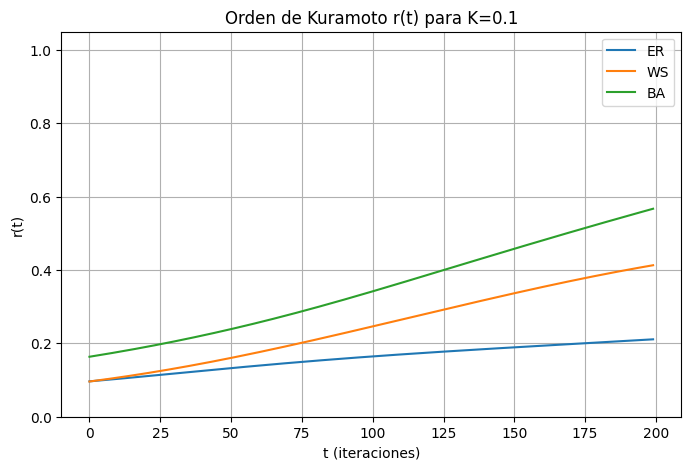

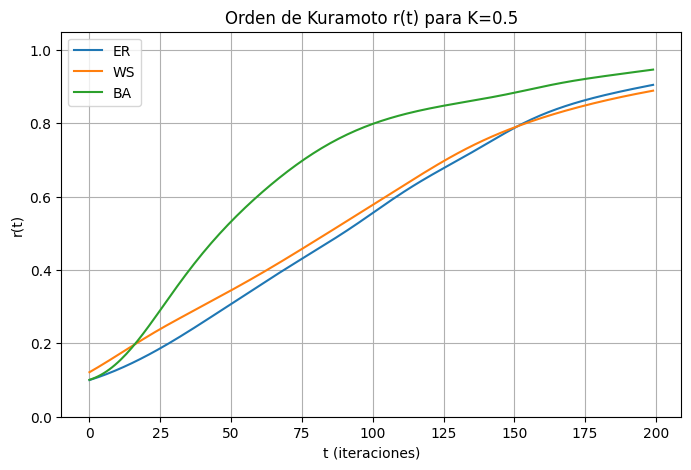

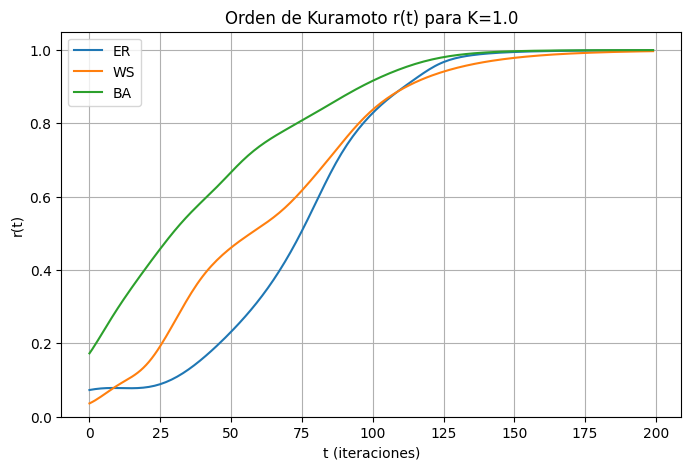

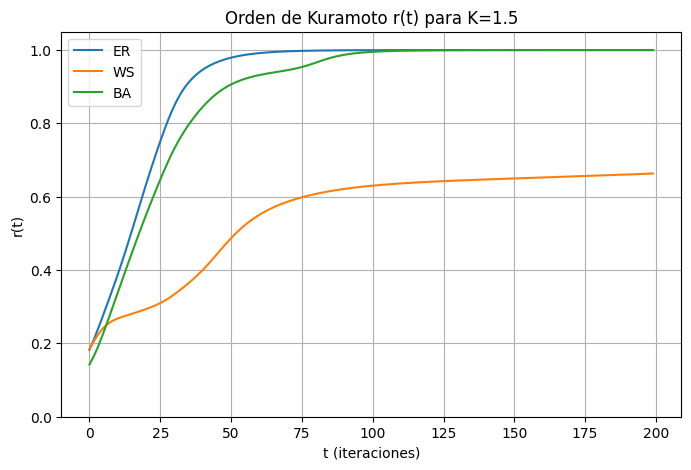

In [4]:
def algebraic_connectivity(L):
    vals = np.sort(np.real(eigvals(L)))
    return vals[1]  # lambda_2

for name, L in laplacians.items():
    lam2 = algebraic_connectivity(L)
    print(f"{name}: lambda_2 ≈ {lam2:.3f}")

# Simulación simplificada de Kuramoto
def simulate_kuramoto(G, K, T=200, dt=0.02):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    omega = 1.0 + 0.01*np.random.randn(N)
    theta = 2*np.pi*np.random.rand(N)
    rs = []  # orden global
    for _ in range(T):
        # término de acoplamiento
        coupling = np.zeros(N)
        for i in range(N):
            coupling[i] = np.sum(A[i,:] * np.sin(theta - theta[i]))
        theta = theta + dt * (omega + K * coupling)
        r = np.abs(np.mean(np.exp(1j*theta)))
        rs.append(r)
    return np.array(rs)

Ks = [0.1, 0.5, 1.0, 1.5]

for K in Ks:
    plt.figure(figsize=(8,5))
    for name, G in graphs.items():
        r = simulate_kuramoto(G, K)
        plt.plot(r, label=name)
    plt.title(f"Orden de Kuramoto r(t) para K={K}")
    plt.xlabel('t (iteraciones)')
    plt.ylabel('r(t)')
    plt.ylim(0,1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


## Ejercicio 3 – Umbral epidémico y topología

Queremos estudiar cómo la topología afecta al **umbral epidémico** en un modelo tipo SIS (Susceptible–Infectado–Susceptible).

Para este tipo de modelo en red, el umbral crítico puede aproximarse por:
$
\lambda_c \approx \frac{1}{\lambda_{\max}(A)},
$
donde $A$ es la matriz de adyacencia y $\lambda_{\max}(A)$ su mayor autovalor.

### Tareas
1. Calcula $\lambda_{\max}(A)$ para las tres redes (ER, WS, BA).
2. Estima el umbral $\lambda_c$ para cada una.
3. Simula un modelo SIS discreto sencillo $I(t)$ y comprueba empíricamente si la infección persiste o se extingue para valores de $\lambda$ por encima y por debajo del umbral teórico.


**Preguntas:**
1. ¿Qué red presenta el umbral epidémico más bajo?  
   **Respuesta:** La BA suele tener el umbral más bajo porque presenta hubs. Esto hace que $\lambda_{\max}(A)$ sea grande y, por tanto, $\lambda_c \approx 1/\lambda_{\max}(A)$ sea pequeño.
2. ¿Qué efecto tienen los hubs en la red BA sobre la propagación?  
   **Respuesta:** Los hubs actúan como superconectores: facilitan la transmisión y mantienen la infección activa incluso con tasas $\beta$ relativamente bajas. Eso reduce el umbral y aumenta la persistencia de la epidemia.
3. ¿Que ocurre si añadimos una gráfica más con $β$ cercana a 1?  
   **Respuesta:** Con $\beta$ muy alta, la infección tiende a persistir en todas las topologías, y $I(t)$ se estabiliza en valores altos. Las diferencias entre redes se atenúan, porque la dinámica está dominada por una infección muy fuerte.

### Ejercicio 3 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

ER: lambda_max(A) ≈ 7.047, lambda_c ≈ 0.142
WS: lambda_max(A) ≈ 6.130, lambda_c ≈ 0.163
BA: lambda_max(A) ≈ 8.467, lambda_c ≈ 0.118


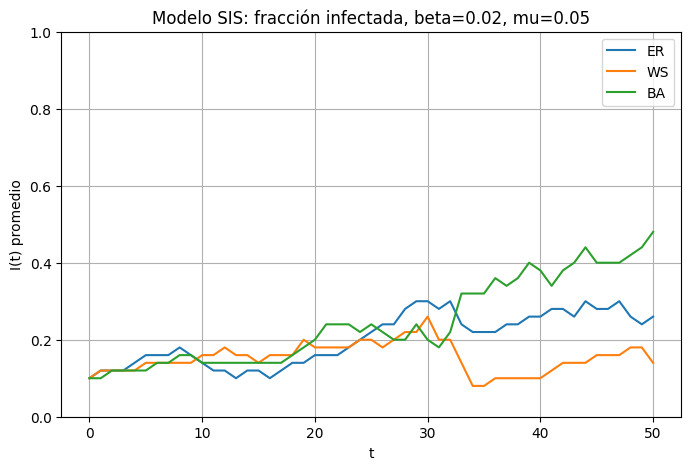

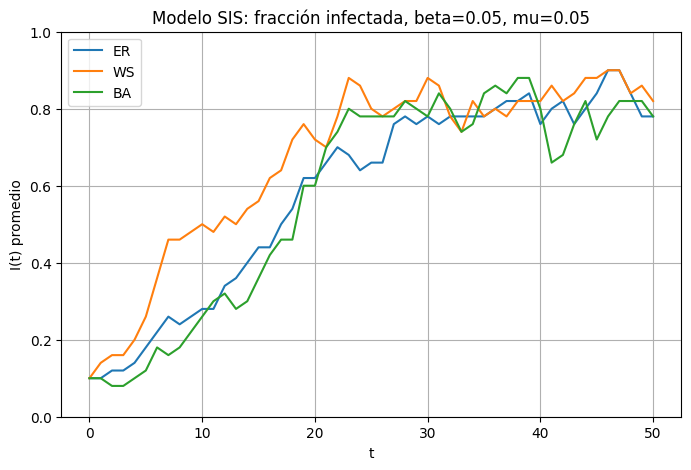

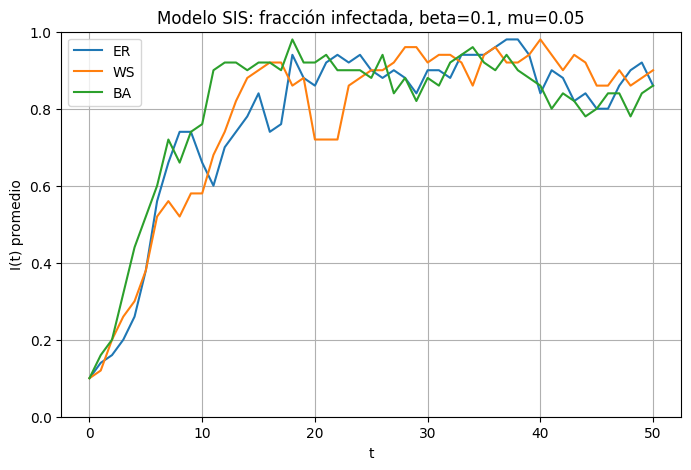

In [5]:
def max_eigenvalue_adjacency(G):
    A = nx.to_numpy_array(G)
    vals = eigvals(A)
    return np.max(np.real(vals))

for name, G in graphs.items():
    lam_max = max_eigenvalue_adjacency(G)
    lambda_c = 1.0 / lam_max
    print(f"{name}: lambda_max(A) ≈ {lam_max:.3f}, lambda_c ≈ {lambda_c:.3f}")

def simulate_SIS(G, beta, mu, T=50, init_frac=0.1):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    x = np.zeros(N, dtype=int)
    infected = np.random.choice(N, int(init_frac*N), replace=False)
    x[infected] = 1
    history = [x.mean()]
    for _ in range(T):
        new_x = x.copy()
        for i in range(N):
            if x[i] == 1:
                # recuperación
                if np.random.rand() < mu:
                    new_x[i] = 0
            else:
                # infección por vecinos
                neigh = np.where(A[i,:]>0)[0]
                if len(neigh) > 0:
                    prob_inf = 1 - np.prod(1 - beta*x[neigh])
                    if np.random.rand() < prob_inf:
                        new_x[i] = 1
        x = new_x
        history.append(x.mean())
    return np.array(history)

betas = [0.02, 0.05, 0.1]
mu = 0.05

for beta in betas:
    plt.figure(figsize=(8,5))
    for name, G in graphs.items():
        hist = simulate_SIS(G, beta, mu)
        plt.plot(hist, label=name)
    plt.title(f"Modelo SIS: fracción infectada, beta={beta}, mu={mu}")
    plt.xlabel('t')
    plt.ylabel('I(t) promedio')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()
